In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import seaborn as sns

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import pandas as pd
import torch

from basicModel import EstimateAngle
from experiments import dataFile_fineTune1

%run discriminationAnalysis.py

# Initial fine tuning experiments

In [2]:
dataSizes = [50, 100, 200]
modelParams = {
    0: [0., 4.],
    1: [np.pi/3, 4.],
    2: [0., 1E-16]
}

reps = [0,1]

Text(0.5, 1.0, 'Length of fine-tuning')

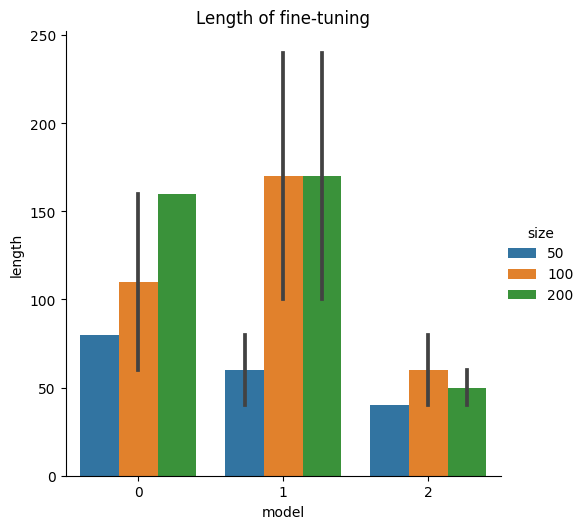

In [3]:
# how long did fine tuning take?

fineTuneLen = pd.DataFrame(columns=['size', 'model', 'rep', 'length'] )

for i, size in enumerate(dataSizes):
    for modeli in range(3):
        for rep in reps:
            files = dataFile_fineTune1(size, *modelParams[modeli][::-1], rep)
            fineTuneLen.loc[-1] = [size, modeli, rep, 20*len(files)]
            fineTuneLen.index = fineTuneLen.index + 1 

sns.catplot(x='model', y='length', hue='size', data=fineTuneLen, kind='bar')
plt.title('Length of fine-tuning')

Very roughly, more data-points means more fine-tuning, and initial training on a flat distribution means less fine-tuning

## The main question is: did fine-tuning lead to differences in sensitivity?

In [4]:
def discriminationAcrossAngles(model):
    thetas = np.linspace(0, np.pi, 21)
    sensitivity = []
    for angle in thetas:
        sensitivity.append( sensitivityIndex( model, angle))
    return thetas, sensitivity

def parseFiles(files):
    fileDict = {}
    for fileName in files:
        epoch = int(fileName.split('=')[1].split('-')[0])
        fileDict[epoch] = fileName

    return fileDict


50
100
200


Text(0.5, 0.98, 'Fine tuning 0 mean to pi/3 mean')

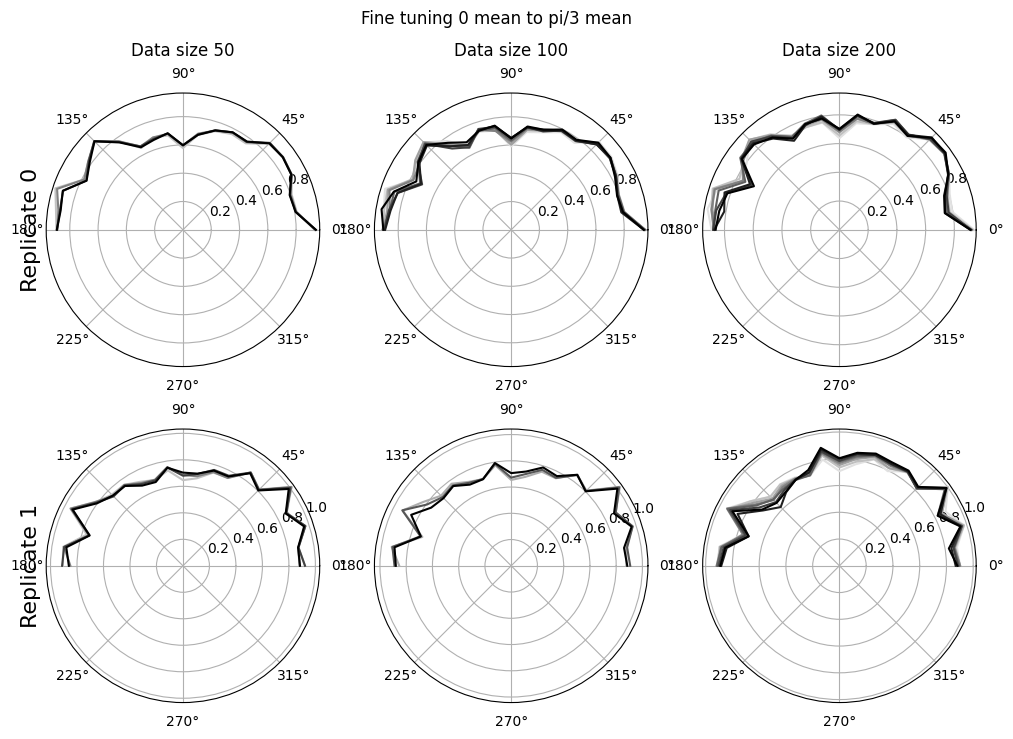

In [5]:
parameters = modelParams[0][::-1]

figsize(12,8)
plt.subplots(2,3, subplot_kw={'projection': 'polar'})

for i, size in enumerate(dataSizes):
    for rep in range(2):
        plt.subplot(2, 3, i+1+3*rep)
        if rep == 0:
            plt.title(f'Data size {size}', pad=8)
        if i == 0:
            plt.ylabel(f'Replicate {rep}', fontsize=16)
        
        fileDict = parseFiles(dataFile_fineTune1(size, *parameters, rep))

        epoch = 19
        maxEpoch = max(fileDict.keys())
        while epoch in fileDict.keys():
            model = EstimateAngle.load_from_checkpoint(fileDict[epoch])
            thetas, sensitivity = discriminationAcrossAngles(model)
            plt.plot(thetas, sensitivity, color=str(1-epoch/maxEpoch) )
            epoch += 20

    print(size)

plt.suptitle('Fine tuning 0 mean to pi/3 mean')

50
100
200


Text(0.5, 0.98, 'Fine tuning pi/3 mean to 0 mean')

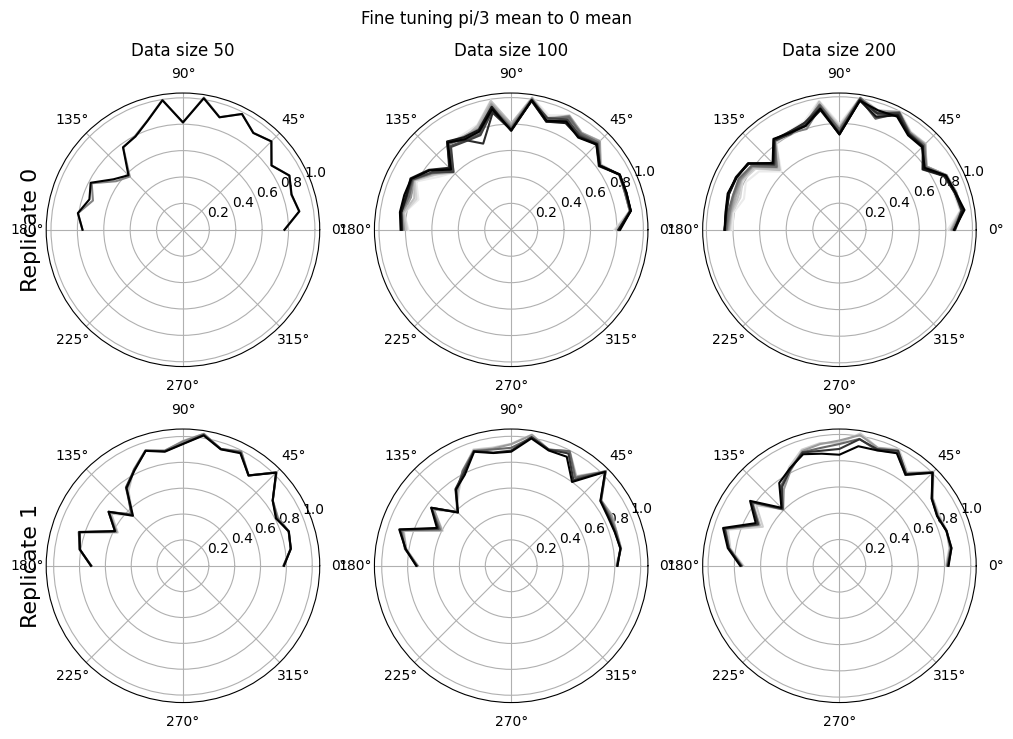

In [6]:
parameters = modelParams[1][::-1]

figsize(12,8)
plt.subplots(2,3, subplot_kw={'projection': 'polar'})

for i, size in enumerate(dataSizes):
    for rep in range(2):
        plt.subplot(2, 3, i+1+3*rep)
        if rep == 0:
            plt.title(f'Data size {size}', pad=8)
        if i == 0:
            plt.ylabel(f'Replicate {rep}', fontsize=16)
        
        fileDict = parseFiles(dataFile_fineTune1(size, *parameters, rep))

        epoch = 19
        maxEpoch = max(fileDict.keys())
        while epoch in fileDict.keys():
            model = EstimateAngle.load_from_checkpoint(fileDict[epoch])
            thetas, sensitivity = discriminationAcrossAngles(model)
            plt.plot(thetas, sensitivity, color=str(1-epoch/maxEpoch) )
            epoch += 20
    print(size)

plt.suptitle('Fine tuning pi/3 mean to 0 mean')

50
100
200


Text(0.5, 0.98, 'Fine tuning flat distribution to pi/3 mean')

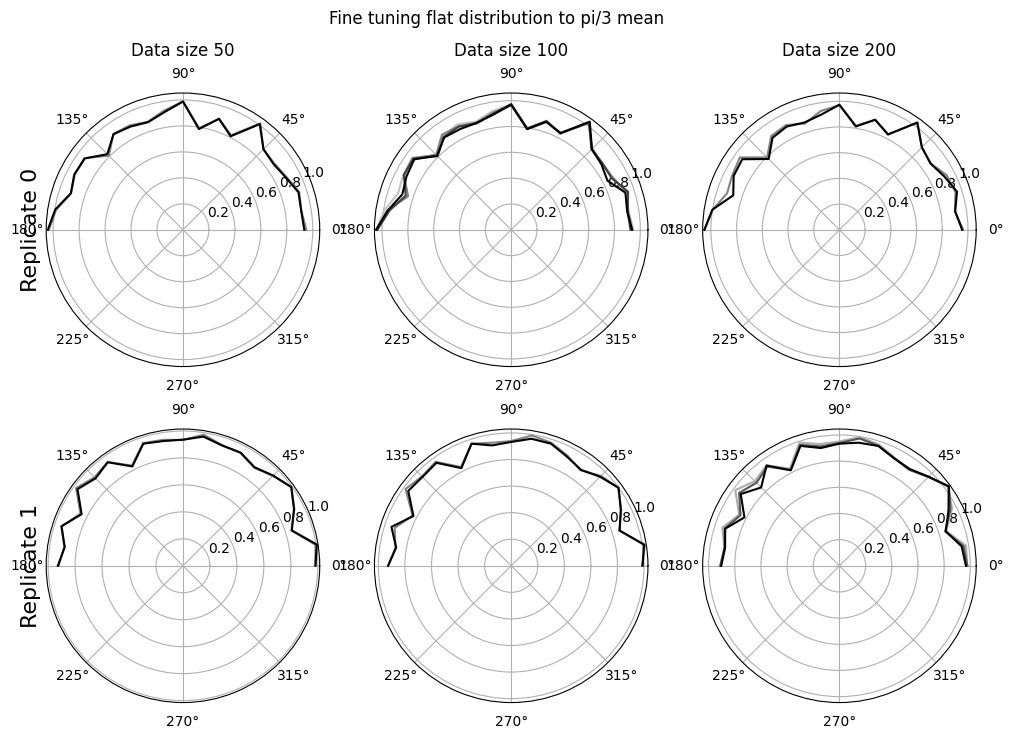

In [7]:
parameters = modelParams[2][::-1]

figsize(12,8)
plt.subplots(2,3, subplot_kw={'projection': 'polar'})

for i, size in enumerate(dataSizes):
    for rep in range(2):
        plt.subplot(2, 3, i+1+3*rep)
        if rep == 0:
            plt.title(f'Data size {size}', pad=8)
        if i == 0:
            plt.ylabel(f'Replicate {rep}', fontsize=16)
        
        fileDict = parseFiles(dataFile_fineTune1(size, *parameters, rep))

        epoch = 19
        maxEpoch = max(fileDict.keys())
        while epoch in fileDict.keys():
            model = EstimateAngle.load_from_checkpoint(fileDict[epoch])
            thetas, sensitivity = discriminationAcrossAngles(model)
            plt.plot(thetas, sensitivity, color=str(1-epoch/maxEpoch) )
            epoch += 20
    print(size)

plt.suptitle('Fine tuning flat distribution to pi/3 mean')

Ok, this is pretty interesting and quite promising. We see evidence of fine-tuning at work.

1. It requires larger numbers of data points, with 50 data-points rarely showing any sign of changes due to the tuning.
2. Interestingly, the flat training set shows much less sign of fine-tuning than the more specialized encodings.
3. We see both expansion of sensitivity in more heavily weighted area, and reduction of sensitivity in under-weighted areas.
    -  this can be divided into a couple different types: removal of the tendencies from the previous training distribution, and adding in the tendencies from the fine-tuning distribution, with both increases and decreases in sensitivity.
    -  can't really draw any conclusions about the prevalence of these behaviors, besides to say that they all show up
  
One major conclusion: more fine-tuning points are better, even beyond what we tested here.